### Import Dependencies

In [76]:
import h5py
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras import utils

#### avoid oom errors by setting gpu memory consumption growth

In [77]:
# grab all the gpus available in the machine
gpus = tf.config.experimental.list_physical_devices('GPU')
# for every gpu set memory growth (making tensorflow to keep the memory only to what it needs)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Dataset / visualize a sample

I will be using the Galaxy10 SDSS Dataset from [astroNN](https://astronn.readthedocs.io/en/latest/index.html). The dataset can be found here: http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5  <br/>
The dataset contains 21785 69x69 pixels colored galaxy images separated in 10 classes as shown below:  <br/>

Galaxy10 dataset (21785 images)  <br/>
├── Class 0 (3461 images): Disk, Face-on, No Spiral  <br/>
├── Class 1 (6997 images): Smooth, Completely round  <br/>
├── Class 2 (6292 images): Smooth, in-between round  <br/>
├── Class 3 (394 images): Smooth, Cigar shaped  <br/>
├── Class 4 (1534 images): Disk, Edge-on, Rounded Bulge  <br/>
├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge  <br/>
├── Class 6 (589 images): Disk, Edge-on, No Bulge  <br/>
├── Class 7 (1121 images): Disk, Face-on, Tight Spiral  <br/>
├── Class 8 (906 images): Disk, Face-on, Medium Spiral  <br/>
└── Class 9 (519 images): Disk, Face-on, Loose Spiral  <br/>

Images come from [Sloan Digital Sky Survey](https://www.sdss.org/) and labels from [Galaxy Zoo](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/).

In [78]:
# get the images and labels from file
with h5py.File('dataset/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# convert to desirable type
labels = labels.astype(np.uint8)
images = images.astype(np.uint8)

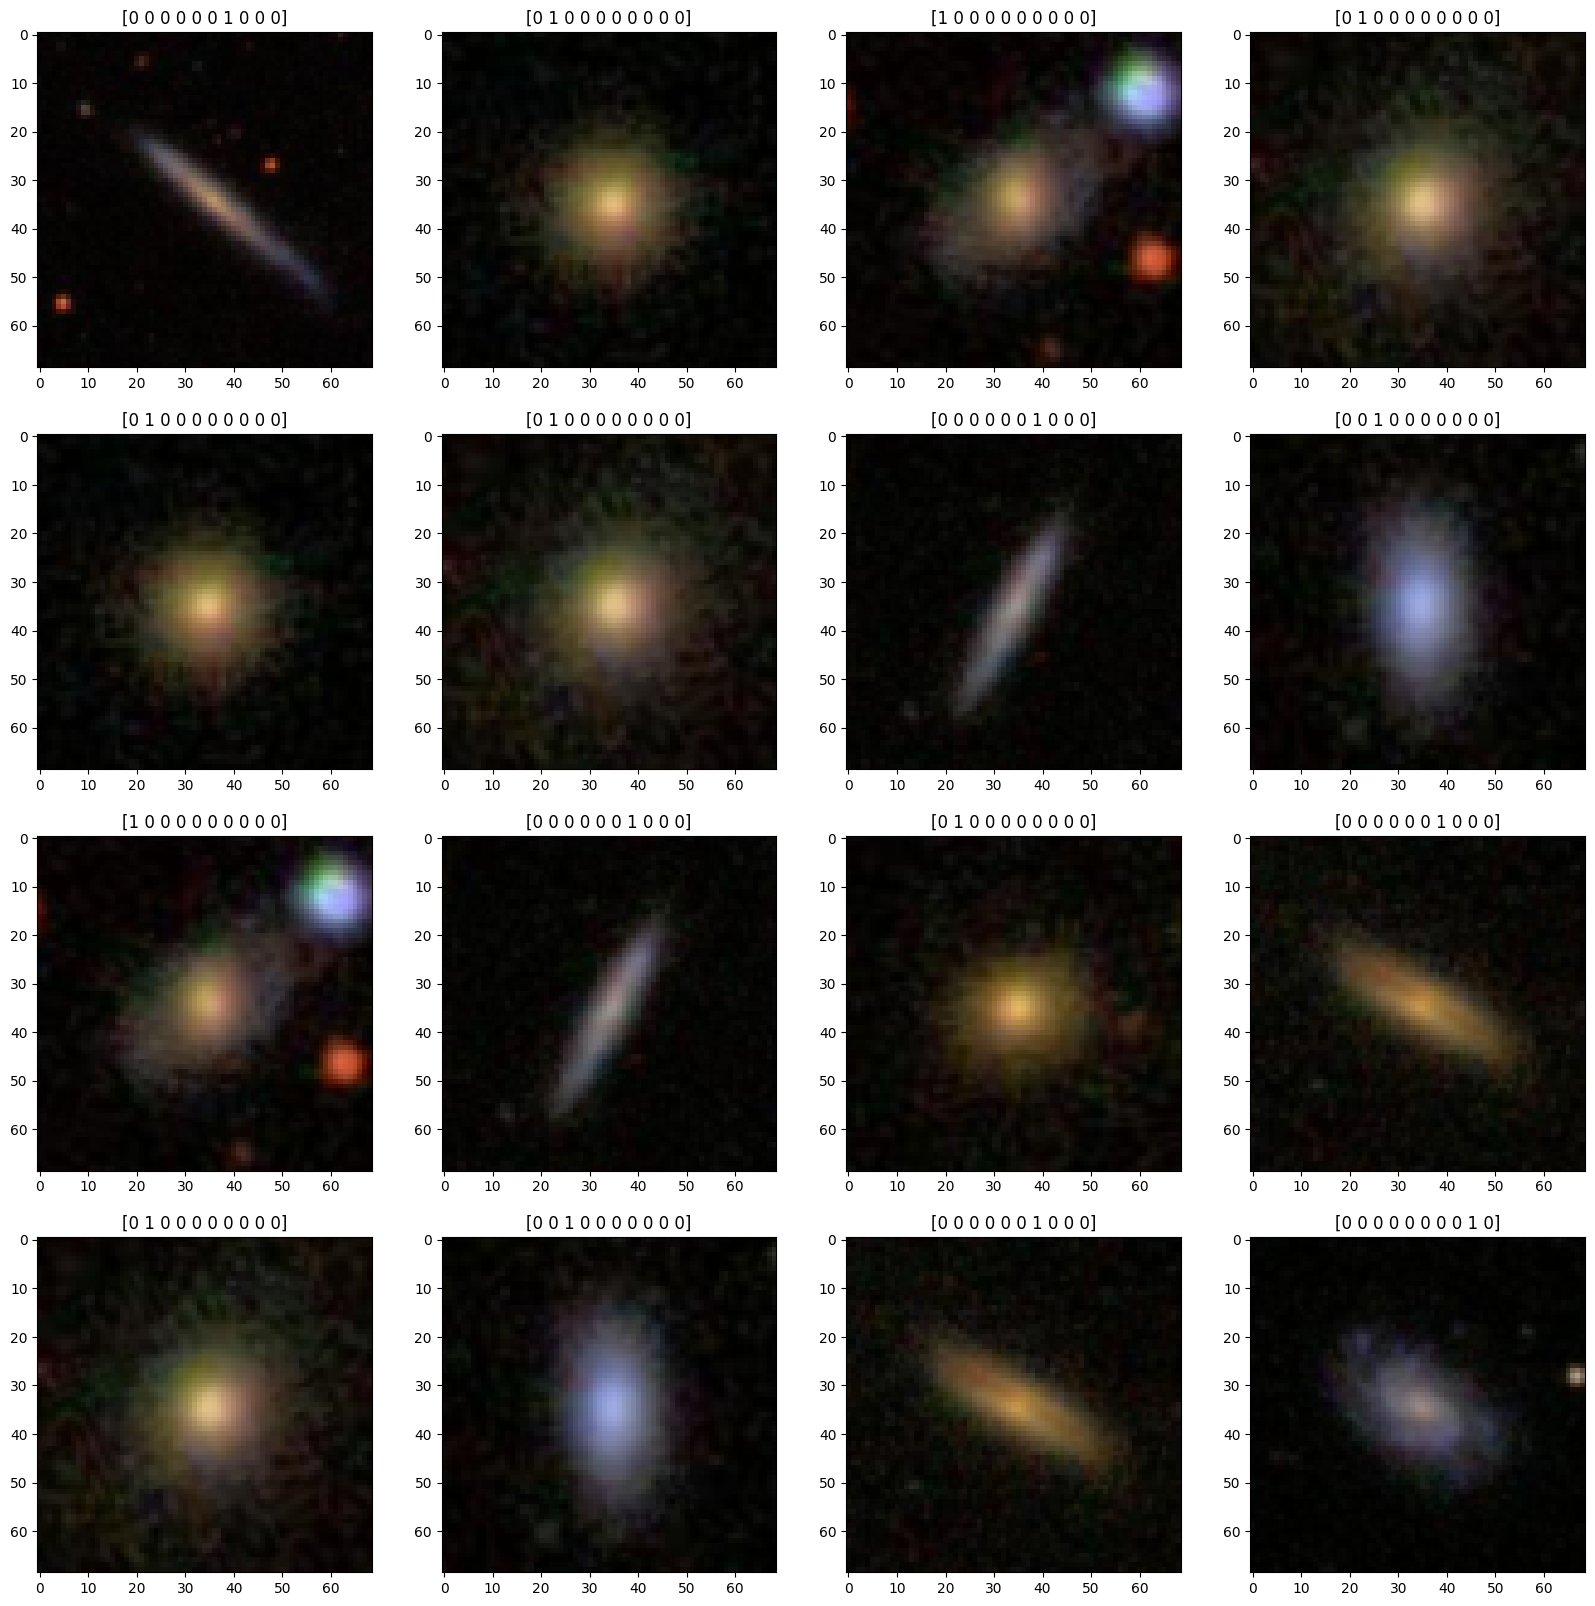

In [81]:
# get 16 random images
num_images = images.shape[0]
random_images = random.sample(range(num_images), 16)
# get their corresponding labels
img = images[random_images]
random_labels = labels[random_images]

# visualize them
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(img[(i+1)*(j+1)-1])
        ax[i][j].title.set_text(random_labels[(i+1)*(j+1)-1])
plt.show()